In [1]:

import os
import random
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from gensim.models import KeyedVectors
from sklearn.linear_model import LogisticRegression
from keras.models import Sequential
from keras.layers import Conv1D, GlobalMaxPooling1D,Dropout, Dense, Embedding, SpatialDropout1D, MaxPooling1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.initializers import Constant
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

# Preparing the Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#%% Load preprocessed data, and split into train a test
new_data = pd.read_csv('/content/drive/MyDrive/NLP_PROJECT/df_train_test.csv')

#TODO Combine summary and review into 1 column
new_data['full_text'] = new_data['reviewText'] + ". " + new_data['summary']

new_data.columns

#Define X and y
X = new_data['full_text']
y = pd.read_csv('/content/drive/MyDrive/NLP_PROJECT/y_train_test.csv')['label_encoded']
#TODO Split data
split = StratifiedShuffleSplit(n_splits = 1, test_size=0.3, random_state=00)

# 30% testing | 70% training
for train_index, test_index in split.split(X, y):
    X_train,  X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [4]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(30800,)
(13200,)
(30800,)
(13200,)


In [5]:
type(X_train)

pandas.core.series.Series

## TFIDF

In [6]:
tfidf = TfidfVectorizer()

# # # Applying to all X variables

# X_train Basic
X_trainTf = tfidf.fit_transform(X_train)

# X_test Basic -- only transform
X_testTf = tfidf.transform(X_test)

# Naive Bayes

In [7]:
nb = MultinomialNB()

# HyperParam Tuning -- GridSearch
#Default alpha = 1
param_grid = {'alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0]}

grid_nb = GridSearchCV(nb, param_grid)
grid_nb.fit(X_trainTf, y_train) # -------> Fitting

GridSearchCV(estimator=MultinomialNB(),
             param_grid={'alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.5, 1.0,
                                   2.0, 5.0, 10.0]})

In [8]:
bestParams = grid_nb.best_params_
print(bestParams)

best_model = grid_nb.best_estimator_
print(best_model)

{'alpha': 0.05}
MultinomialNB(alpha=0.05)


In [9]:
# Using Cross Validation Score
scores = cross_val_score(best_model, X_trainTf, y_train, cv=10, scoring="accuracy")

print ('All scores:', scores)
print  ('Average score:', scores.mean())

All scores: [0.79058442 0.79318182 0.8038961  0.80032468 0.80292208 0.80097403
 0.80422078 0.79415584 0.80422078 0.81233766]
Average score: 0.8006818181818183


In [10]:
# # # Testing Set
nb_Pred = best_model.predict(X_testTf)
cmtest = confusion_matrix(y_test, nb_Pred, labels = np.arange(0,3))

print (cmtest)

[[3570  689  141]
 [ 668 3438  294]
 [ 309  418 3673]]


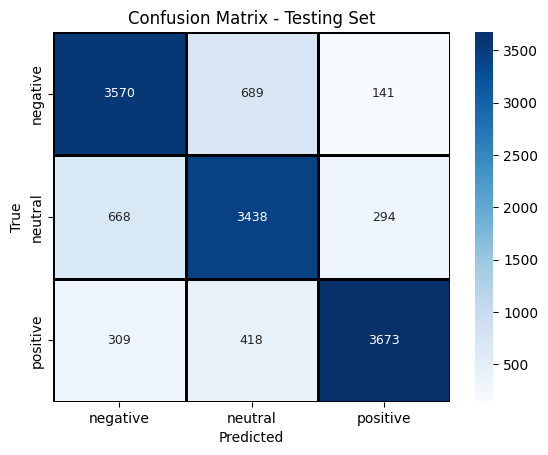

In [11]:
# Plotting Confusion Matrix
target_names=['negative', 'neutral', 'positive']

axTft = sns.heatmap(cmtest, annot=True, annot_kws={'size': 9},fmt='g', xticklabels=target_names, yticklabels=target_names, cmap='Blues', linewidths=1, linecolor='black')
axTft.set_xlabel ('Predicted', fontsize=10)
axTft.set_ylabel('True', fontsize=10)
plt.title ('Confusion Matrix - Testing Set')
plt.axis()
plt.show()

In [12]:
# Report Testing
nb_report = classification_report(y_test, nb_Pred, target_names=target_names)
print(nb_report)

              precision    recall  f1-score   support

    negative       0.79      0.81      0.80      4400
     neutral       0.76      0.78      0.77      4400
    positive       0.89      0.83      0.86      4400

    accuracy                           0.81     13200
   macro avg       0.81      0.81      0.81     13200
weighted avg       0.81      0.81      0.81     13200



# Logistic Regression

Embeddings

In [13]:
word2vec_path = '/content/drive/MyDrive/NLP_PROJECT/GoogleNews-vectors-negative300.bin'

# Load the model
w2v_model = KeyedVectors.load_word2vec_format(word2vec_path, binary=True)



def embedding_feats(rows):
    DIMENSION = 300
    feats = []
    for tokens in rows:
        feat_for_this = np.zeros(DIMENSION)
        count_for_this = 0
        for token in tokens:
            if token in w2v_model:
                feat_for_this += w2v_model[token]
                count_for_this += 1
        if count_for_this > 0:
            feats.append(feat_for_this / count_for_this)
        else:
            feats.append(np.zeros(DIMENSION))  # Replace nan with zeros

    return feats


train_vectors = embedding_feats(X_train)
print(len(train_vectors))

test_vectors = embedding_feats (X_test)
print(len(test_vectors))

30800
13200


In [14]:
nan_indices_train = np.isnan(train_vectors).any(axis=1)
print("Number of nan values in train_vectors:", np.sum(nan_indices_train))

# Check for nan values in test_vectors
nan_indices_test = np.isnan(test_vectors).any(axis=1)
print("Number of nan values in test_vectors:", np.sum(nan_indices_test))

Number of nan values in train_vectors: 0
Number of nan values in test_vectors: 0


## Model TF-IDF

In [15]:
max_iter = 500
verbose = 100

lr = LogisticRegression(max_iter=max_iter)

# # # Hyperparam tunning
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10],   # Inverse of regularization strength
    'solver': ['newton-cg', 'sag', 'saga', 'lbfgs']}


grid_lr = GridSearchCV(lr, param_grid)
grid_lr.fit(X_trainTf, y_train)

GridSearchCV(estimator=LogisticRegression(max_iter=500),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10],
                         'solver': ['newton-cg', 'sag', 'saga', 'lbfgs']})

In [16]:
bestParamsLr = grid_lr.best_params_
print (bestParamsLr)

bestEstLr = grid_lr.best_estimator_
print(bestEstLr)

{'C': 10, 'solver': 'sag'}
LogisticRegression(C=10, max_iter=500, solver='sag')


In [17]:
scoreLr = cross_val_score(bestEstLr, X_trainTf, y_train, scoring='accuracy',
                          cv=10)

print ('All scores:', scoreLr)
print  ('Average score:', scoreLr.mean())

All scores: [0.85454545 0.85194805 0.85616883 0.8487013  0.85064935 0.86103896
 0.86525974 0.8461039  0.86753247 0.85681818]
Average score: 0.8558766233766233


In [18]:
# # # Testing Set
Lr_pred = bestEstLr.predict(X_testTf)
cmLr = confusion_matrix(y_test, Lr_pred, labels = np.arange(0,3))

print (cmLr)

[[3732  529  139]
 [ 402 3802  196]
 [ 183  352 3865]]


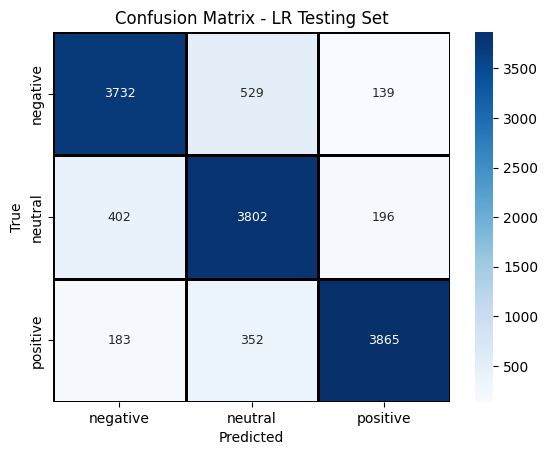

In [19]:
# # Confusion Matrix

axLr = sns.heatmap(cmLr, annot=True, annot_kws={'size': 9},fmt='g', xticklabels=target_names, yticklabels=target_names, cmap='Blues', linewidths=1, linecolor='black')
axLr.set_xlabel ('Predicted', fontsize=10)
axLr.set_ylabel('True', fontsize=10)
plt.title ('Confusion Matrix - LR Testing Set')
plt.axis()
plt.show()

In [20]:
# Report Testing
LrReport = classification_report(y_test, Lr_pred, target_names=target_names)
print(LrReport)

              precision    recall  f1-score   support

    negative       0.86      0.85      0.86      4400
     neutral       0.81      0.86      0.84      4400
    positive       0.92      0.88      0.90      4400

    accuracy                           0.86     13200
   macro avg       0.87      0.86      0.86     13200
weighted avg       0.87      0.86      0.86     13200



## Model - Embeddings

In [21]:
lr2 = LogisticRegression(max_iter = 1000)
grid_lr2 = GridSearchCV(lr2, param_grid)
grid_lr2.fit(train_vectors, y_train)

GridSearchCV(estimator=LogisticRegression(max_iter=1000),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10],
                         'solver': ['newton-cg', 'sag', 'saga', 'lbfgs']})

In [22]:
bestParamsLr2 = grid_lr2.best_params_
print (bestParamsLr2)

bestEstLr2 = grid_lr2.best_estimator_
print(bestEstLr2)

{'C': 10, 'solver': 'sag'}
LogisticRegression(C=10, max_iter=1000, solver='sag')


In [23]:
# Cross Validation Score
scoreLr2 = cross_val_score(bestEstLr2, train_vectors, y_train, scoring='accuracy', cv=10)

print ('All scores:', scoreLr2)
print  ('Average score:', scoreLr2.mean())

All scores: [0.57077922 0.56915584 0.58149351 0.5711039  0.57662338 0.6012987
 0.59480519 0.56461039 0.58181818 0.56818182]
Average score: 0.5779870129870129


In [24]:
# # # Testing Set
Lr_pred2 = bestEstLr2.predict(test_vectors)
cmLr2 = confusion_matrix(y_test, Lr_pred2, labels = np.arange(0,3))

print (cmLr2)

[[2607 1156  637]
 [1438 2215  747]
 [ 755  844 2801]]


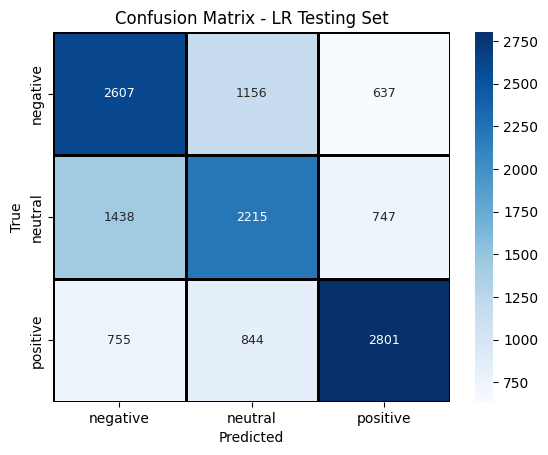

In [25]:
axLr2 = sns.heatmap(cmLr2, annot=True, annot_kws={'size': 9},fmt='g', xticklabels=target_names, yticklabels=target_names, cmap='Blues', linewidths=1, linecolor='black')
axLr2.set_xlabel ('Predicted', fontsize=10)
axLr2.set_ylabel('True', fontsize=10)
plt.title ('Confusion Matrix - LR Testing Set')
plt.axis()
plt.show()

In [26]:
# Report Testing
LrReport2 = classification_report(y_test, Lr_pred2, target_names=target_names)
print(LrReport2)

              precision    recall  f1-score   support

    negative       0.54      0.59      0.57      4400
     neutral       0.53      0.50      0.51      4400
    positive       0.67      0.64      0.65      4400

    accuracy                           0.58     13200
   macro avg       0.58      0.58      0.58     13200
weighted avg       0.58      0.58      0.58     13200



# CNN

In [27]:
# Params for embedding matrix and layer
max_num_words = 10000
max_sequence = 50
emb_dim = 300


'''  ------ Tokenizer, sequences and more ------  '''

tokenizer = Tokenizer(num_words=max_num_words)
tokenizer.fit_on_texts(X_train)

# Converting text to a vector of word indexes; will be used to get the vector
# from w2v and to form the embedding matrix to feed the Embedding Layer
train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)
word_index = tokenizer.word_index


In [28]:
''' -------- Padding ---------------'''

X_train_final = pad_sequences(train_sequences, maxlen=max_sequence)
X_test_final = pad_sequences(test_sequences, maxlen=max_sequence)


''' --------- To Categorical -----------------'''
y_trainCat = to_categorical(y_train, num_classes=3)
y_testCat = to_categorical(y_test, num_classes=3)


In [29]:

''' ---------------  Word2 Vec  ------------- '''

'''
word_index is a dictionary of all the unique words in the corpus with a unique
integer number given by Keras' tokenizer.

'''


num_words_w2v = min(max_num_words, len(word_index)) + 1
embedding_matrix_w2v = np.zeros((num_words_w2v, emb_dim))

for key, val in word_index.items():
    if val > max_num_words:
        continue

    if key in w2v_model:
        embedding_vector= w2v_model.get_vector(key)
    else:
        embedding_vector = np.zeros(emb_dim)

    embedding_matrix_w2v[val] = embedding_vector


embedding_layer_w2v = Embedding(input_dim=num_words_w2v, output_dim=emb_dim,
                          embeddings_initializer=Constant(embedding_matrix_w2v),
                          input_length=max_sequence, trainable = False)

In [30]:

cnn_model = Sequential()
cnn_model.add(embedding_layer_w2v)
cnn_model.add(Conv1D(256, 3, activation='relu', padding='same'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(64, activation='relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(3, activation='softmax'))
cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

cnn_model.fit(X_train_final, y_trainCat, batch_size=16, epochs=15, validation_split=0.2, callbacks=[early_stopping])


Epoch 1/15
1540/1540 [==============================] - 49s 31ms/step - loss: 0.8579 - acc: 0.5816 - val_loss: 0.6340 - val_acc: 0.7443
Epoch 2/15
1540/1540 [==============================] - 51s 33ms/step - loss: 0.6518 - acc: 0.7148 - val_loss: 0.5474 - val_acc: 0.7680
Epoch 3/15
1540/1540 [==============================] - 50s 32ms/step - loss: 0.5744 - acc: 0.7560 - val_loss: 0.5099 - val_acc: 0.7940
Epoch 4/15
1540/1540 [==============================] - 46s 30ms/step - loss: 0.5290 - acc: 0.7782 - val_loss: 0.4741 - val_acc: 0.8047
Epoch 5/15
1540/1540 [==============================] - 48s 31ms/step - loss: 0.4846 - acc: 0.8018 - val_loss: 0.4578 - val_acc: 0.8185
Epoch 6/15
1540/1540 [==============================] - 49s 32ms/step - loss: 0.4522 - acc: 0.8191 - val_loss: 0.4304 - val_acc: 0.8300
Epoch 7/15
1540/1540 [==============================] - 54s 35ms/step - loss: 0.4172 - acc: 0.8360 - val_loss: 0.4290 - val_acc: 0.8282
Epoch 8/15
1540/1540 [==========================

In [31]:
score, acc = cnn_model.evaluate(X_test_final, y_testCat)
print('Test accuracy with CNN:', acc)

413/413 [==============================] - 8s 19ms/step - loss: 0.4055 - acc: 0.8586
Test accuracy with CNN: 0.8586363792419434
